In [1]:
#Data Handling
import pandas as pd
import numpy as np
import tifffile
from math import pi
import os

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Data Manipulation
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema
from scipy.signal import argrelmax
from scipy.signal import find_peaks
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind


In [3]:
dict_of_mutants = {
    'jRGECO1a': ['Results01','Results02','Results03','Results04','Results06','Results07','Results08'],
    'A318I': ['Results09','Results10','Results11','Results12','Results13','Results15','Results16'],
    'M354A': ['Results17','Results18','Results19','Results20','Results21','Results22','Results23','Results24'],
    'M354V': ['Results25','Results26','Results27','Results28','Results29','Results30','Results31','Results32'],
    'R393V': ['Results33', 'Results34','Results35','Results36','Results37','Results39','Results40'],
    'L415A': ['Results41','Results42','Results43','Results44','Results45','Results46','Results47','Results48'],          
    'L415G': ['Results49','Results50','Results51','Results52','Results53','Results54','Results55','Results56'],
    'L415V':['Results57','Results58','Results59','Results60','Results61','Results62','Results63','Results64']
}

variant_color_map = {
    'jRGECO1a': '#2F5DFF',
    'R393V':    '#66B2FF',
    'L415A':    '#9B30FF',
    'M354V':    '#FF2E63',
    'M354A':    '#FF7518',
    'L415V':    '#F1E14C',
    'L415G':    '#32CD32',
    'A318I':    '#00D28A'
}


In [4]:
path_1 = "C:/Users/Shuyu/Downloads/neuron/"
last_bit = '.csv'
output_folder = "C:/Users/Shuyu/Downloads/results"
os.makedirs(output_folder, exist_ok=True)

In [5]:
df_list_F0 = []
df_list_deltaF_F0 = []
all_F0_values = {}
all_values = {}

for variant, files in dict_of_mutants.items():
    F0_variant = []
    deltaF_F0_variant = []

    for file in files:
        file_path = os.path.join(path_1, file + last_bit)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, index_col=0)
            
            for col in df.columns:
                F0 = df[col][:25].mean()
                max_deltaF = df[col][-60:].max()
                deltaF_F0 = (max_deltaF - F0) / F0

                F0_variant.append(F0)
                deltaF_F0_variant.append(deltaF_F0)

                df_list_F0.append({'variant': variant, 'F0': F0})
                df_list_deltaF_F0.append({'variant': variant, 'deltaF_F0': deltaF_F0})

    all_F0_values[variant] = F0_variant
    all_values[variant] = deltaF_F0_variant

df_plot_F0 = pd.DataFrame(df_list_F0)
df_plot_deltaF_F0 = pd.DataFrame(df_list_deltaF_F0)

df_plot_F0_filtered = df_plot_F0[df_plot_F0["F0"] <= 200]

C:\Users\Shuyu\AppData\Local\Temp\ipykernel_23004\3933640016.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


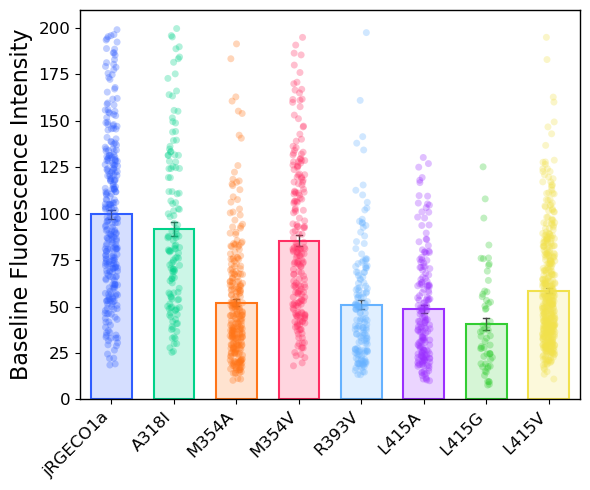

In [7]:
plt.figure(figsize=(6, 5))
ax = sns.barplot(
    data=df_plot_F0_filtered, x="variant", y="F0", estimator=np.mean,
    errorbar="se", capsize=0.1, err_kws={"linewidth": 1.0},
    edgecolor="black", linewidth=1, width=0.65,
    palette=variant_color_map
)

for bar, variant in zip(ax.patches, df_plot_F0_filtered['variant'].unique()):
    base_color = variant_color_map[variant]
    rgba_color = (*mcolors.to_rgb(base_color), 0.2)
    edge_rgba = (*mcolors.to_rgb(base_color), 0.3) 
    bar.set_facecolor(rgba_color)
    bar.set_edgecolor(base_color)
    bar.set_linewidth(1.5)

# stripplot
sns.stripplot(
    data=df_plot_F0_filtered, x="variant", y="F0", hue="variant",
    palette=variant_color_map, size=5, jitter=True, alpha=0.3, dodge=False
)

"""
for variant, p_value in p_values.items():
    y_max = df_plot_F0_filtered[df_plot_F0_filtered['variant'] == variant]['F0'].max() + 10
    if p_value < 0.001:
        plt.text(x=df_plot_F0_filtered['variant'].unique().tolist().index(variant), y=y_max, s='***', ha='center', va='bottom', fontsize=14)
    elif p_value < 0.01:
        plt.text(x=df_plot_F0_filtered['variant'].unique().tolist().index(variant), y=y_max, s='**', ha='center', va='bottom', fontsize=14)
    elif p_value < 0.05:
        plt.text(x=df_plot_F0_filtered['variant'].unique().tolist().index(variant), y=y_max, s='*', ha='center', va='bottom', fontsize=14)
"""

for spine in ax.spines.values():
    spine.set_linewidth(1)

plt.ylabel("Baseline Fluorescence Intensity", fontsize=16)
plt.xlabel("")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=45, ha='right', va='top')
plt.legend([], [], frameon=False)
plt.tight_layout()

output_file = os.path.join(output_folder, "Baseline_Fluorescence_Intensity.pdf")
plt.savefig(output_file, format='pdf')
plt.show()

In [8]:
from matplotlib.ticker import FuncFormatter

df_plot_deltaF_F0['deltaF_F0_percent'] = df_plot_deltaF_F0['deltaF_F0'] * 100

p_values_deltaF_F0 = {}
for variant in df_plot_deltaF_F0['variant'].unique():
    if variant != 'jRGECO1a':
        group_1 = df_plot_deltaF_F0[df_plot_deltaF_F0['variant'] == 'jRGECO1a']['deltaF_F0_percent']
        group_2 = df_plot_deltaF_F0[df_plot_deltaF_F0['variant'] == variant]['deltaF_F0_percent']
        
        _, p_value = ttest_ind(group_1, group_2)
        p_values_deltaF_F0[variant] = p_value

C:\Users\Shuyu\AppData\Local\Temp\ipykernel_23004\3390259912.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


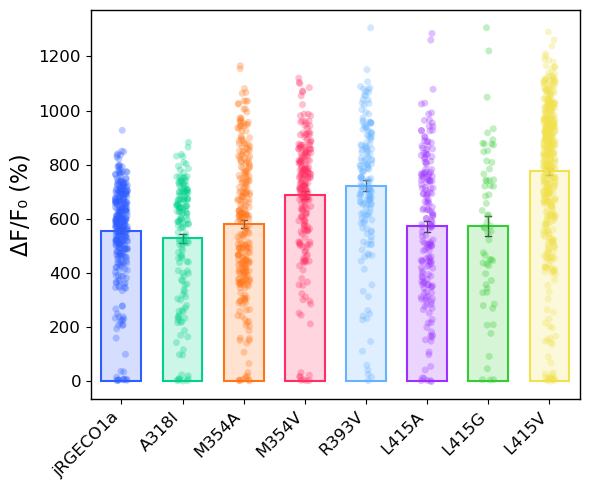

In [9]:
plt.figure(figsize=(6, 5))
ax = sns.barplot(
    data=df_plot_deltaF_F0, x="variant", y="deltaF_F0_percent", estimator=np.mean,
    errorbar="se", capsize=0.1, err_kws={"linewidth": 1.0},
    edgecolor="black", linewidth=1, width=0.65,
    palette=variant_color_map
)

for bar, variant in zip(ax.patches, df_plot_F0_filtered['variant'].unique()):
    base_color = variant_color_map[variant]
    rgba_color = (*mcolors.to_rgb(base_color), 0.2)
    edge_rgba = (*mcolors.to_rgb(base_color), 0.3) 
    bar.set_facecolor(rgba_color)
    bar.set_edgecolor(base_color)
    bar.set_linewidth(1.5)

# stripplot
sns.stripplot(
    data=df_plot_deltaF_F0, x="variant", y="deltaF_F0_percent", hue="variant",
    palette=variant_color_map, size=5, jitter=True, alpha=0.3, dodge=False
)

for spine in ax.spines.values():
    spine.set_linewidth(1)

plt.ylabel("ΔF/F₀ (%)", fontsize=16)
plt.xlabel("")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=45, ha='right', va='top')
plt.legend([], [], frameon=False)
plt.tight_layout()

output_file = os.path.join(output_folder, "deltaF_F0_percent.pdf")
plt.savefig(output_file, format='pdf')
plt.show()


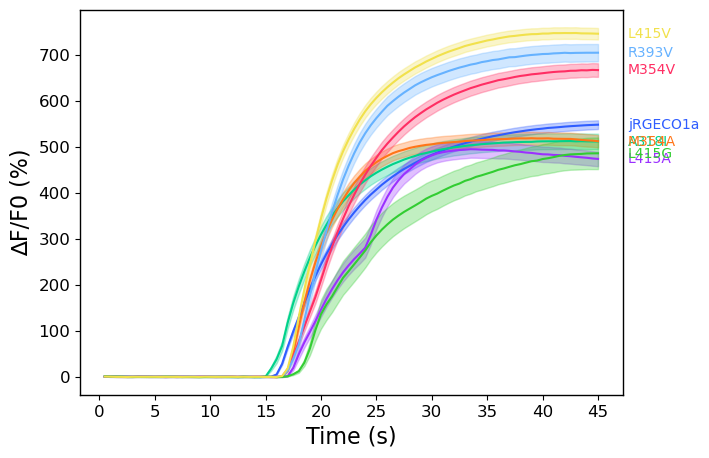

In [21]:
all_time_series_dff = {}
all_sem_series_dff = {}

for variant, files in dict_of_mutants.items():
    all_experiments_deltaF_F0 = []

    for file in files:
        file_path = os.path.join(path_1, file + last_bit)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, index_col=0)

            F0 = df.iloc[:30, :].mean(axis=0)
            
            deltaF_F0_series = (df - F0) / F0 * 100
            
            all_experiments_deltaF_F0.append(deltaF_F0_series)

    if all_experiments_deltaF_F0:
        combined_df = pd.concat(all_experiments_deltaF_F0, axis=1)
        mean_deltaF_F0 = combined_df.mean(axis=1)
        sem_deltaF_F0 = combined_df.sem(axis=1)
        
        all_time_series_dff[variant] = mean_deltaF_F0
        all_sem_series_dff[variant] = sem_deltaF_F0

plt.figure(figsize=(7, 5))

for variant, time_series in all_time_series_dff.items():
    sem_series = all_sem_series_dff[variant]
    color = variant_color_map.get(variant, 'black')

    time_in_seconds = time_series.index * 0.5  

    plt.plot(time_in_seconds, time_series.values, label=variant, color=color)

    plt.fill_between(time_in_seconds, 
                     time_series - sem_series, 
                     time_series + sem_series, 
                     color=color, alpha=0.3)


    plt.text(
        time_in_seconds[-1] * 1.06,         
        time_series.values[-1],
        variant,                 
        color=color, fontsize=10,
        verticalalignment='center'
    )


plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Time (s)", fontsize = 16)
plt.ylabel("∆F/F0 (%)",  fontsize = 16)
#plt.legend(fontsize = 10)

max_time = max(time_in_seconds)
plt.xticks(np.arange(0, max_time + 1, 5))

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1)

output_file = os.path.join(output_folder, "Time_Series.pdf")
plt.savefig(output_file, format='pdf')
plt.show()

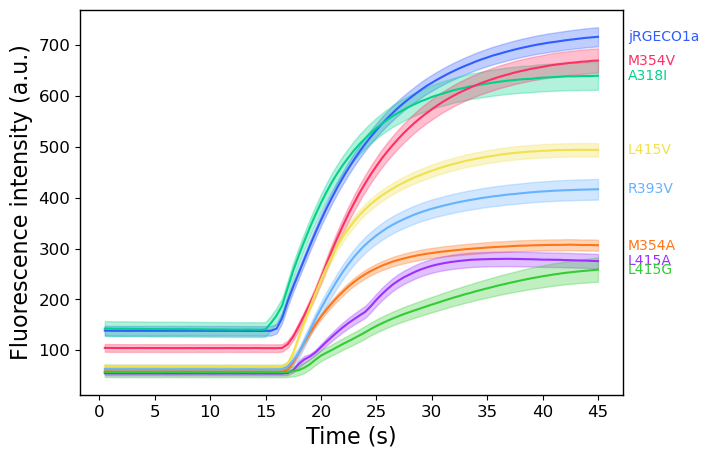

In [22]:
all_time_series_F = {}
all_sem_series_F = {}

for variant, files in dict_of_mutants.items():
    all_experiments_F = []

    for file in files:
        file_path = os.path.join(path_1, file + last_bit)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, index_col=0)

            all_experiments_F.append(df)

    if all_experiments_F:
        combined_df = pd.concat(all_experiments_F, axis=1)
        mean_F = combined_df.mean(axis=1)
        sem_F = combined_df.sem(axis=1)
        
        all_time_series_F[variant] = mean_F
        all_sem_series_F[variant] = sem_F

plt.figure(figsize=(7, 5))

for variant, time_series in all_time_series_F.items():
    sem_series = all_sem_series_F[variant]
    color = variant_color_map.get(variant, 'black')

    time_in_seconds = time_series.index * 0.5

    plt.plot(time_in_seconds, time_series.values, label=variant, color=color)

    plt.fill_between(time_in_seconds, 
                     time_series - sem_series, 
                     time_series + sem_series, 
                     color=color, alpha=0.3)

    plt.text(
        time_in_seconds[-1] * 1.06,
        time_series.values[-1],
        variant,
        color=color, fontsize=10,
        verticalalignment='center'
    )

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Fluorescence intensity (a.u.)", fontsize=16)
# plt.legend(fontsize=10)

max_time = max(time_in_seconds)
plt.xticks(np.arange(0, max_time + 1, 5))

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1)

output_file = os.path.join(output_folder, "Fluorescence_Time_Series.pdf")
plt.savefig(output_file, format='pdf')
plt.show()


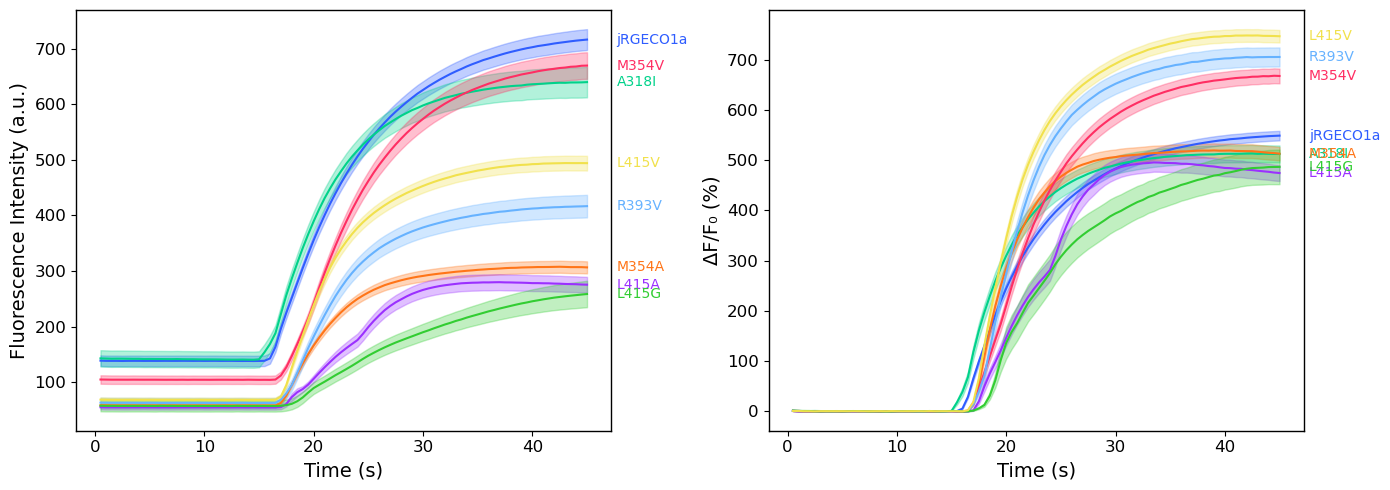

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Left: original F
for variant, time_series in all_time_series_F.items():
    sem_series = all_sem_series_F[variant]
    color = variant_color_map.get(variant, 'black')
    time_in_seconds = time_series.index * 0.5

    axs[0].plot(time_in_seconds, time_series.values, label=variant, color=color)
    axs[0].fill_between(time_in_seconds, time_series - sem_series, time_series + sem_series,
                        color=color, alpha=0.3)
    axs[0].text(time_in_seconds[-1] * 1.06, time_series.values[-1], variant,
                color=color, fontsize=10, verticalalignment='center')

axs[0].set_xlabel("Time (s)", fontsize=14)
axs[0].set_ylabel("Fluorescence Intensity (a.u.)", fontsize=14)
axs[0].tick_params(axis='both', labelsize=12)
axs[0].spines['bottom'].set_linewidth(1)
axs[0].spines['left'].set_linewidth(1)
axs[0].spines['right'].set_linewidth(1)
axs[0].spines['top'].set_linewidth(1)

# Right: ΔF/F0 %
for variant, time_series in all_time_series_dff.items():
    sem_series = all_sem_series_dff[variant]
    color = variant_color_map.get(variant, 'black')
    time_in_seconds = time_series.index * 0.5

    axs[1].plot(time_in_seconds, time_series.values, label=variant, color=color)
    axs[1].fill_between(time_in_seconds, time_series - sem_series, time_series + sem_series,
                        color=color, alpha=0.3)
    axs[1].text(time_in_seconds[-1] * 1.06, time_series.values[-1], variant,
                color=color, fontsize=10, verticalalignment='center')

axs[1].set_xlabel("Time (s)", fontsize=14)
axs[1].set_ylabel("ΔF/F₀ (%)", fontsize=14)
axs[1].tick_params(axis='both', labelsize=12)
axs[1].spines['bottom'].set_linewidth(1)
axs[1].spines['left'].set_linewidth(1)
axs[1].spines['right'].set_linewidth(1)
axs[1].spines['top'].set_linewidth(1)

plt.tight_layout()
output_file = os.path.join(output_folder, "Time_Series.pdf")
plt.savefig(output_file, format='pdf')
plt.show()

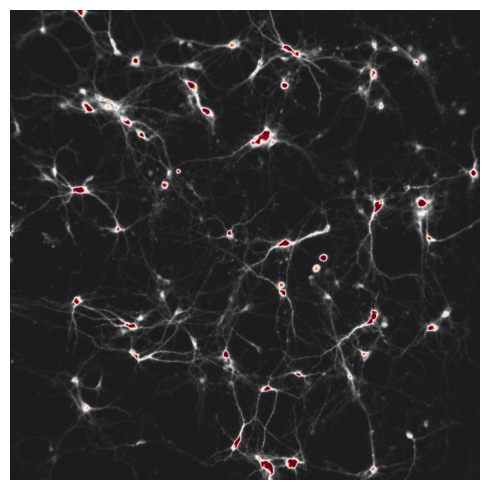

In [ ]:
tif_file_path = 'C:/Users/Shuyu/Downloads/BS50/sample_64.tif'
with tifffile.TiffFile(tif_file_path) as tif:
    frame = tif.pages[80].asarray()

vmin_value = np.min(0)
vmax_value = np.max(1000)

plt.figure(figsize=(5, 5))
plt.axis('off') 
plt.imshow(frame, cmap='RdGy_r', aspect='auto', vmin=vmin_value, vmax=vmax_value)
#plt.imshow(frame, cmap='RdGy_r', aspect='auto')
#plt.colorbar(label='Fluorescence Intensity')
output_file = os.path.join(output_folder, "64.pdf")
plt.savefig(output_file, format='pdf')
plt.tight_layout()

plt.show()

C:\Users\Shuyu\AppData\Local\Temp\ipykernel_19424\4194841492.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax.imshow(gradient, aspect='auto', cmap=cm.get_cmap(name))
C:\Users\Shuyu\AppData\Local\Temp\ipykernel_19424\4194841492.py:14: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


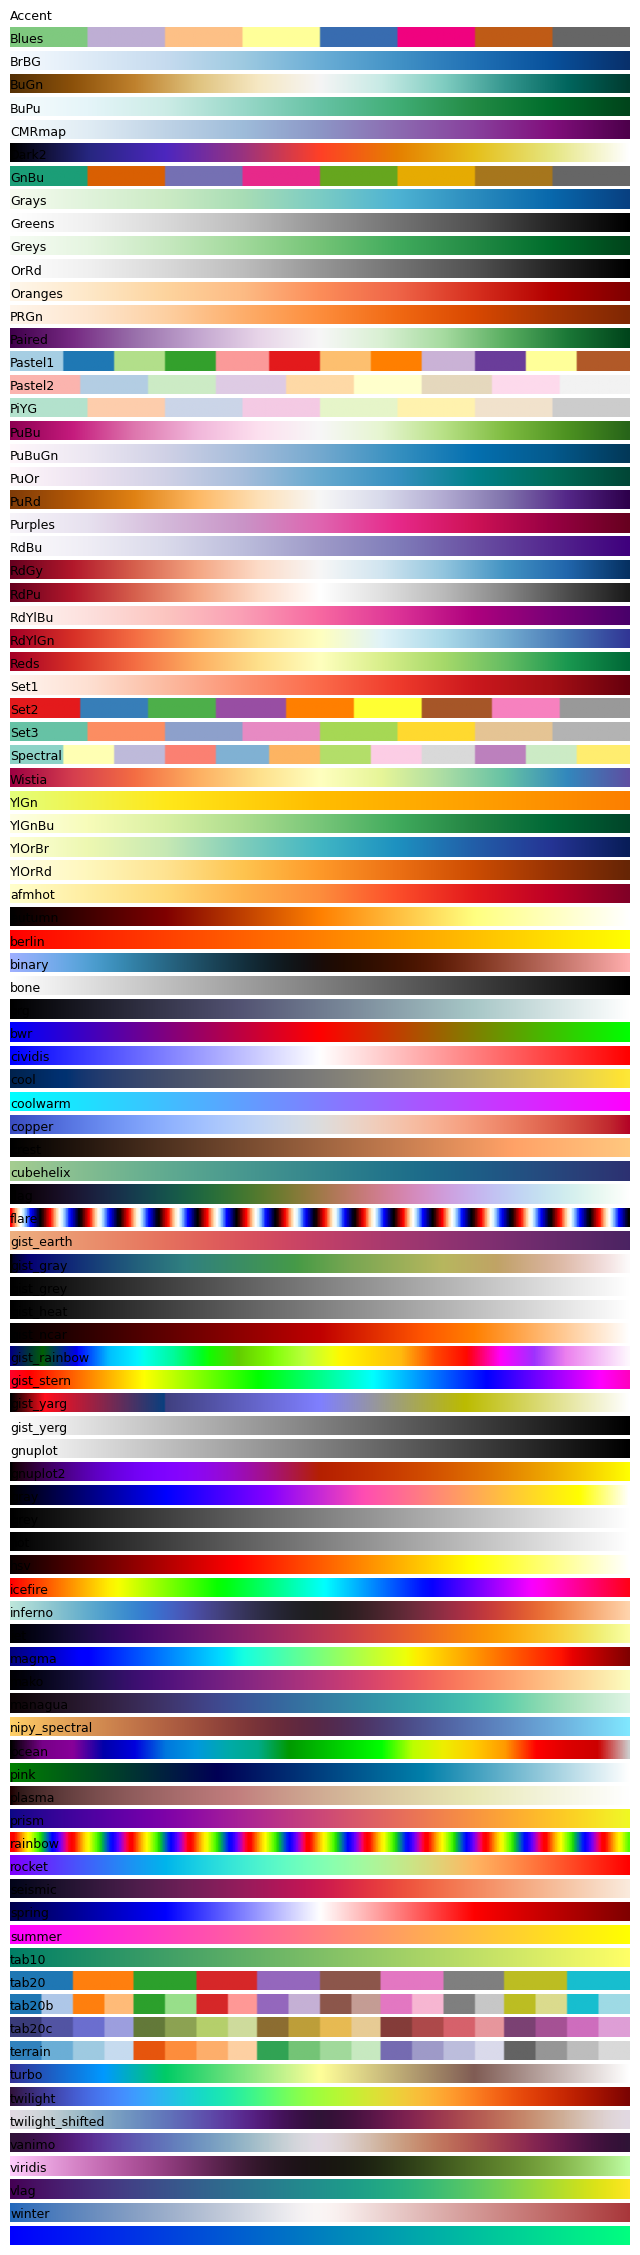

In [72]:
cmap_list = [m for m in plt.colormaps() if not m.endswith("_r")]
cmap_list.sort()

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, axes = plt.subplots(len(cmap_list), 1, figsize=(8, 0.3 * len(cmap_list)))

for ax, name in zip(axes, cmap_list):
    ax.imshow(gradient, aspect='auto', cmap=cm.get_cmap(name))
    ax.set_axis_off()
    ax.set_title(name, fontsize=9, loc='left')

plt.tight_layout()
plt.show()
